In [0]:
pip install livelossplot

# **Imports & Constants**

In [0]:
import numpy as np
import cv2
import glob
import random
import datetime

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.engine.saving import load_model
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras.backend as kb
from livelossplot.keras import PlotLossesCallback

MAIN_DIR_PATH = "drive/My Drive/Colab Notebooks/assignment3"
LOGS = MAIN_DIR_PATH + "/logs"
IMG_WIDTH = 128
IMG_HEIGHT = 128

from google.colab import drive

Using TensorFlow backend.


# **Mount Google Drive**

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **Data Function Definitions**

In [0]:
def load_image(path):
    """
    Returns a loaded image at the given path

    :param path: the path from which to load the image
    """

    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return img


def load_data(input_path, label_path, augment=False):
    """
    Returns processed data from the given paths. Data is returned in two
    arrays: feature array, expected output array

    If augment==True, then the returned arrays would additionally contain
    augmented data.

    :param input_path: a relative path to all the input data
    :param label_path: a relative path to all the labels
    :param augment: whether to augment data
    """

    img_paths = glob.glob(input_path + "/*")
    mask_paths = glob.glob(label_path + "/*")
    img_paths.sort()
    mask_paths.sort()

    img_list = []
    mask_list = []

    for f in range(len(img_paths)):
        img = load_image(img_paths[f])

        # Convert mask to grayscale and reshape
        mask = load_image(mask_paths[f])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))

        # Normalize data
        img = img.astype(np.float32)
        mask = mask.astype(np.float32)
        img, mask = normalize_data(img, mask)

        img_list.append(img)
        mask_list.append(mask)

        # If augment is required, then augment the image and mask and
        # also add to the list
        if augment:
            img2, mask2 = augment_data(img, mask.squeeze())
            img_list.append(img2)
            mask_list.append(np.reshape(mask2, (mask2.shape[0], mask2.shape[1], 1)))

    return np.array(img_list), np.array(mask_list)


def normalize_data(img, mask):
    """
    Normalizes and returns the given image and mask
    :param img: the image
    :param mask: the mask
    """

    if np.max(img) > 1:
        img = img / 255
        mask = mask / 255
        mask[mask >= 0.5] = 1
        mask[mask < 0.5] = 0

    return img, mask


def augment_data(img, mask):
    """
    Performs multiple randomly generated augmentations to the image and its mask.

    Augmentations performed:
        - Flips (x-axis and y-axis)
        - Rotations
        - Zooms
        - Sheers

    :param img: the image
    :param mask: the mask
    """
    # 50% change of flipping on x-axis
    if random.random() >= 0.5:
        img = cv2.flip(img, 0)
        mask = cv2.flip(mask, 0)

    # 50% change of flipping on y-axis
    if random.random() >= 0.5:
        img = cv2.flip(img, 1)
        mask = cv2.flip(mask, 1)

    # Rotate randomly
    rot_m = cv2.getRotationMatrix2D((img.shape[0] / 2, img.shape[1] / 2), random.uniform(0, 360), 1)
    img = cv2.warpAffine(img, rot_m, (img.shape[0], img.shape[1]))
    mask = cv2.warpAffine(mask, rot_m, (img.shape[0], img.shape[1]))

    # Warp Affine (shear)
    pt1 = 5 + 20 * np.random.uniform() - 20 / 2
    pt2 = 50 + 20 * np.random.uniform() - 20 / 2
    pts1 = np.float32([[5, 5], [50, 5], [5, 50]])
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    shear_m = cv2.getAffineTransform(pts1, pts2)
    img = cv2.warpAffine(img, shear_m, (img.shape[0], img.shape[1]))
    mask = cv2.warpAffine(mask, shear_m, (img.shape[0], img.shape[1]))

    # Translation
    x = 10 * np.random.uniform() - 5 / 2
    y = 10 * np.random.uniform() - 5 / 2
    trans_m = np.float32([[1, 0, x], [0, 1, y]])
    img = cv2.warpAffine(img, trans_m, (img.shape[0], img.shape[1]))
    mask = cv2.warpAffine(mask, trans_m, (img.shape[0], img.shape[1]))

    return img, mask

# **Model Function Definitions**

In [0]:
def dice_coef(y_true, y_pred):
    """
    Returns the dice-coefficient of the given tensors.

    :param y_true: tensor representing true data
    :param y_pred: tensor representing predicted data
    """
    y_true = kb.flatten(y_true)
    y_pred = kb.flatten(y_pred)
    intersection = kb.sum(y_true * y_pred)
    left = kb.sum(y_true)
    right = kb.sum(y_pred)
    dice = (2.0 * intersection) / (left + right + 1e-7)
    return kb.mean(dice)


def dice_coef_np(y_true, y_pred):
    """
        Returns the dice-coefficient of the given numpy arrays.

        :param y_true: numpy array representing true data
        :param y_pred: numpy array representing predicted data
        """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    left = np.sum(y_true)
    right = np.sum(y_pred)
    dice = (2.0 * intersection) / (left + right + 1e-7)
    return np.mean(dice)


def dice_coef_loss(y_true, y_pred):
    """
    Returns the dice-coefficient loss on the given tensors.

    :param y_true: tensor representing true data
    :param y_pred: tensor representing predicted data
    """
    return 1 - dice_coef(y_true, y_pred)


def conv2d_block(name, x, filters, kernel_size, padding, activation):
    conv = Conv2D(name=name, filters=filters, kernel_size=kernel_size, padding=padding)(x)
    conv = BatchNormalization()(conv)
    conv = Activation(activation=activation)(conv)
    return conv


def unet_model(input_size):
    inputs = Input(name="input1", shape=input_size)
    conv1 = conv2d_block(name="conv1", x=inputs, filters=64, kernel_size=3, padding="same", activation="relu")
    conv2 = conv2d_block(name="conv2", x=conv1, filters=64, kernel_size=3, padding="same", activation="relu")
    maxpool1 = MaxPool2D(name="maxpool1", pool_size=(2, 2), strides=2)(conv2)

    conv3 = conv2d_block(name="conv3", x=maxpool1, filters=128, kernel_size=3, padding="same", activation="relu")
    conv4 = conv2d_block(name="conv4", x=conv3, filters=128, kernel_size=3, padding="same", activation="relu")
    maxpool2 = MaxPool2D(name="maxpool2", pool_size=(2, 2), strides=2)(conv4)

    conv5 = conv2d_block(name="conv5", x=maxpool2, filters=256, kernel_size=3, padding="same", activation="relu")
    conv6 = conv2d_block(name="conv6", x=conv5, filters=256, kernel_size=3, padding="same", activation="relu")
    maxpool3 = MaxPool2D(name="maxpool3", pool_size=(2, 2), strides=2)(conv6)

    conv7 = conv2d_block(name="conv7", x=maxpool3, filters=512, kernel_size=3, padding="same", activation="relu")
    conv8 = conv2d_block(name="conv8", x=conv7, filters=512, kernel_size=3, padding="same", activation="relu")
    maxpool4 = MaxPool2D(name="maxpool4", pool_size=(2, 2), strides=2)(conv8)

    conv9 = conv2d_block(name="conv9", x=maxpool4, filters=1024, kernel_size=3, padding="same", activation="relu")
    conv10 = conv2d_block(name="conv10", x=conv9, filters=1024, kernel_size=3, padding="same", activation="relu")
    upconv1 = UpSampling2D(name="upconv1", size=(2, 2))(conv10)

    concat1 = concatenate(name="concat1", inputs=[conv8, upconv1], axis=3)
    conv11 = conv2d_block(name="conv11", x=concat1, filters=512, kernel_size=3, padding="same", activation="relu")
    conv12 = conv2d_block(name="conv12", x=conv11, filters=512, kernel_size=3, padding="same", activation="relu")
    upconv2 = UpSampling2D(name="upconv2", size=(2, 2))(conv12)

    concat2 = concatenate(name="concat2", inputs=[conv6, upconv2], axis=3)
    conv13 = conv2d_block(name="conv13", x=concat2, filters=256, kernel_size=3, padding="same", activation="relu")
    conv14 = conv2d_block(name="conv14", x=conv13, filters=256, kernel_size=3, padding="same", activation="relu")
    upconv3 = UpSampling2D(name="upconv3", size=(2, 2))(conv14)

    concat3 = concatenate(name="concat3", inputs=[conv4, upconv3], axis=3)
    conv15 = conv2d_block(name="conv15", x=concat3, filters=128, kernel_size=3, padding="same", activation="relu")
    conv16 = conv2d_block(name="conv16", x=conv15, filters=128, kernel_size=3, padding="same", activation="relu")
    upconv4 = UpSampling2D(name="upconv4", size=(2, 2))(conv16)

    concat4 = concatenate(name="concat4", inputs=[conv2, upconv4], axis=3)
    conv17 = conv2d_block(name="conv17", x=concat4, filters=64, kernel_size=3, padding="same", activation="relu")
    conv18 = conv2d_block(name="conv18", x=conv17, filters=64, kernel_size=3, padding="same", activation="relu")
    conv19 = Conv2D(name="conv19", filters=1, kernel_size=1, activation="sigmoid")(conv18)

    u_model = Model(input=inputs, output=conv19)

    return u_model

# **Visual Function Definitions**

In [0]:
def plot_model_history(model_results):
    """
    Plots Loss and Accuracy graphs for the given model results.
    
    :param model_results: the model results from which to retrieve graph data
    """
    plt.figure(figsize=(8, 9))

    plt.subplot(2, 1, 1)
    if "loss" in model_results.history.keys():
        plt.plot(model_results.history["loss"], label="Training Loss")
    if "val_loss" in model_results.history.keys():
        plt.plot(model_results.history["val_loss"], label="Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.title("Training and Validation Loss")

    plt.subplot(2, 1, 2)
    if "acc" in model_results.history.keys():
        plt.plot(model_results.history["acc"], label="Training Accuracy")
    if "val_acc" in model_results.history.keys():
        plt.plot(model_results.history["val_acc"], label="Validation Accuracy")
    if "dice_coef" in model_results.history.keys():
        plt.plot(model_results.history['dice_coef'], label="Dice Coefficient")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.title("Training and Validation Accuracy")
    
    plt.show()


def visualize_segmentations_with_contours(images, ground_masks, pred_masks, save_path=""):
    """
    Visualizes the predicted masks by drawing them as contours on their corresponding images.

    :param images: the list of images
    :param ground_masks: the list of ground truth masks for the image
    :param pred_masks: the list of predicted masks for the image
    :param save_path: path to save all the images (if empty, then images won't be saved)
    """
    for i in range(len(pred_masks)):
        p_mask = pred_masks[i].squeeze()
        p_mask[p_mask >= 0.5] = 255
        p_mask[p_mask < 0.5] = 0
        p_mask = p_mask.astype(np.uint8)
        dice_index = dice_coef_np(ground_masks[i].squeeze(), p_mask)

        # Apply cv2.threshold() to get a binary image
        _, thresh = cv2.threshold(p_mask, 50, 255, cv2.THRESH_BINARY)
        _, contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        img = images[i].copy()
        for contour in contours:
            cv2.drawContours(img, contour, -1, (0, 255, 0), 1)

        figure = plt.figure(figsize=(10, 10))
        plt.subplot(231), plt.imshow(p_mask)
        plt.subplot(222), plt.imshow(img)

        plt.title("Dice Index: " + str(dice_index))

        plt.show()
        if save_path is not None or save_path != "":
            figure.savefig(save_path + "/result_" + str(i) + ".png", dpi=100, bbox_inches='tight')


def visualize_segmentations(images, ground_masks, pred_masks, save_path=""):
    """
    Visualizes the predicted masks by drawing the images, ground truth masks, and predicted masks separately in
    a single figure.

    :param images: the list of images
    :param ground_masks: the list of ground truth masks for the image
    :param pred_masks: the list of predicted masks for the image
    :param save_path: path to save all the images (if empty, then images won't be saved)
    """
    for i in range(len(pred_masks)):
        p_mask = pred_masks[i].squeeze()
        p_mask[p_mask >= 0.5] = 1
        p_mask[p_mask < 0.5] = 0
        dice_index = dice_coef_np(ground_masks[i].squeeze(), p_mask)

        figure = plt.figure(figsize=(10, 10))
        plt.subplot(231), plt.imshow(images[i])
        plt.subplot(232), plt.imshow(ground_masks[i].squeeze())
        plt.subplot(233), plt.imshow(p_mask)

        plt.title("Dice Index: " + str(dice_index))

        plt.show()
        if save_path is not None or save_path != "":
            figure.savefig(save_path + "/result_" + str(i) + ".png", dpi=100, bbox_inches='tight')

# **Training Function Definitions**

In [0]:
def test_model(model, input_path, output_path, visualize_func=None):
    """
    Tests the model on the given data and optionally visualizes it.

    :param model: the model to test with
    :param input_path: path to the input data (ie. test_X)
    :param output_path: path to the output data (ie. test_y)
    :param visualize_func: a function that takes (images, ground_masks, pred_masks, save_path) and visualizes them
    """
    x_test, y_test = load_data(input_path, output_path, False)
    y_pred = model.predict(x_test)

    if visualize_func is not None:
        visualize_func(x_test, y_test, y_pred, MAIN_DIR_PATH + "/results")


def train_model(input_path, output_path, model_name="unet_model", augment=False, lr=1e-4, epochs=10, valid_split=0,
                early_stop=False, model=None):
    """
    Returns a trained model and the training history.

    :param input_path: path to all the input data (ie. train_X)
    :param output_path: path to all the output data (ie. train_y)
    :param augment: whether or not the augment the data
    :param model_name: name of the new model (weights will be saved under this name)
    :param lr: learning rate for model
    :param epochs: number of epochs to run for
    :param valid_split: percentage of data that should be used for validation
    :param early_stop: whether or not to stop early if the validation and training curves diverge too much
    :param model: an existing model to train
    """
    train_x, train_y = load_data(input_path, output_path, augment)

    if model is None:
        model = unet_model((IMG_WIDTH, IMG_HEIGHT, 3))
        model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=[dice_coef])

    # Setup training callbacks
    callbacks = []
    if early_stop:
        callbacks.append(EarlyStopping(monitor='val_loss', verbose=1, patience=50))
    callbacks.append(ModelCheckpoint(MAIN_DIR_PATH + "/" + model_name + ".hdf5", save_weights_only=True))
    callbacks.append(PlotLossesCallback())

    history = model.fit(train_x, train_y, epochs=epochs, validation_split=valid_split, callbacks=callbacks)

    plot_model_history(history)

    return model, history


def train_for_transfer_learning(input_path, output_path, model_name, trained_model_name, fine_tune_at, augment=False,
                                lr=1e-3, epochs=10, valid_split=0, early_stop=False):
    """
    Returns a trained model and the training history. Uses the weights of an already trained model
    to fine-tune the new model.

    :param input_path: path to all the input data (ie. train_X)
    :param output_path:  path to all the output data (ie. train_y)
    :param model_name: name of the new model (weights will be saved under this name)
    :param trained_model_name: name of an already trained model to get the weights from (must exist in main directory)
    :param fine_tune_at: from which layer to start fine tuning at (all layers before this will be frozen)
    :param augment: whether or not the augment the data
    :param lr: learning rate for model
    :param epochs: number of epochs to run for
    :param valid_split: percentage of data that should be used for validation
    :param early_stop: whether or not to stop early if the validation and training curves diverge too much
    """
    model = unet_model((IMG_WIDTH, IMG_HEIGHT, 3))
    model.load_weights(MAIN_DIR_PATH + "/" + trained_model_name + ".hdf5")

    # Fine tune up to a specific layer
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    # Train like normal
    new_model, history = train_model(input_path=input_path, output_path=output_path, model_name=model_name, 
                                     augment=augment, lr=lr, epochs=epochs, valid_split=valid_split, 
                                     early_stop=early_stop, model=model)

    return new_model, history

## **Normal Training**

**Train model and plot information**

In [0]:
cat_model, cat_model_hist = train_model(MAIN_DIR_PATH + "/data/cat_data/Train/input", 
                                        MAIN_DIR_PATH + "/data/cat_data/Train/mask",
                                        model_name="cat_model", augment=False,
                                        lr=1e-3, epochs=200, valid_split=0.1, early_stop=True)

# **Transfer Learning**

**Train model on horse data**

In [0]:
horse_model, horse_model_hist = train_model(MAIN_DIR_PATH + "/data/horse_data/Train/input", 
                                            MAIN_DIR_PATH + "/data/horse_data/Train/mask",
                                            model_name="horse_model", augment=False, 
                                            epochs=150, valid_split=0.1, early_stop=True)

**Create new model for cat data and fine tune it**

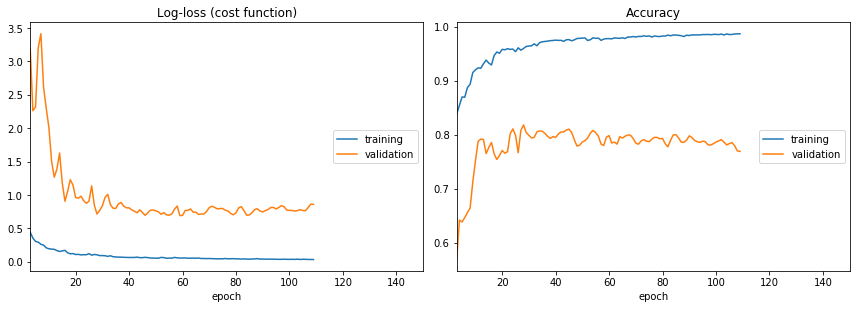

Log-loss (cost function):
training   (min:    0.034, max:    1.750, cur:    0.034)
validation (min:    0.692, max:    5.896, cur:    0.860)

Accuracy:
training   (min:    0.709, max:    0.987, cur:    0.987)
validation (min:    0.502, max:    0.818, cur:    0.769)
Epoch 00109: early stopping


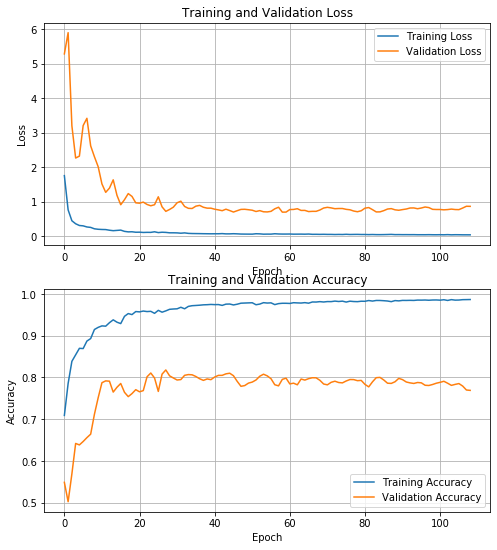

In [0]:
cat_model_t, cat_model_hist_t = train_for_transfer_learning(MAIN_DIR_PATH + "/data/cat_data/Train/input", 
                                                            MAIN_DIR_PATH + "/data/cat_data/Train/mask",
                                                            "cat_model", "horse_model_weights", augment=False, 
                                                            fine_tune_at=15, lr=1e-3, epochs=150, valid_split=0.1, early_stop=True)

# **Testing**

**Test & Visualize**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


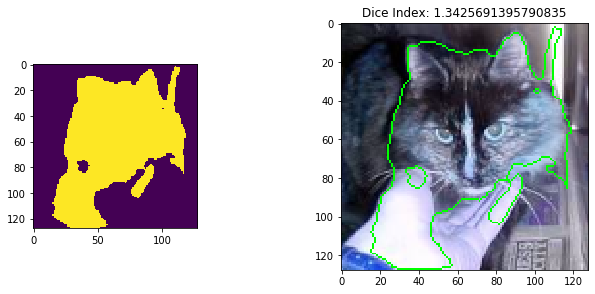

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


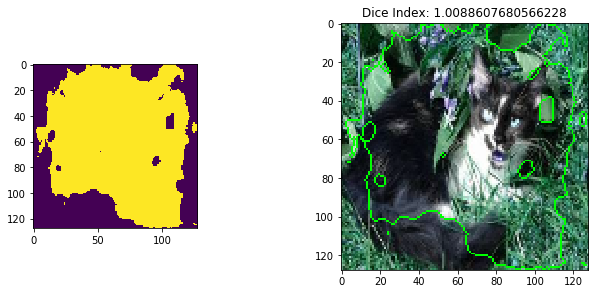

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


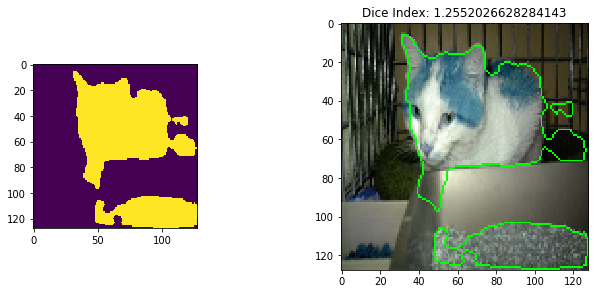

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


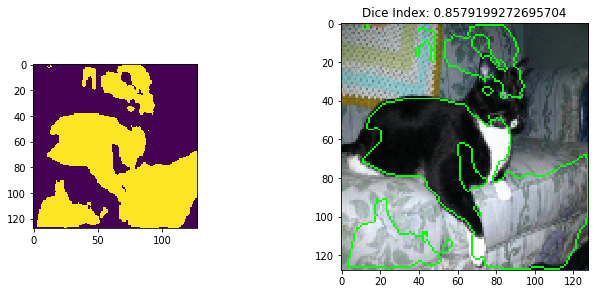

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


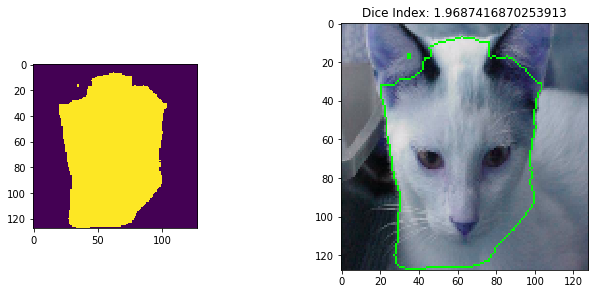

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


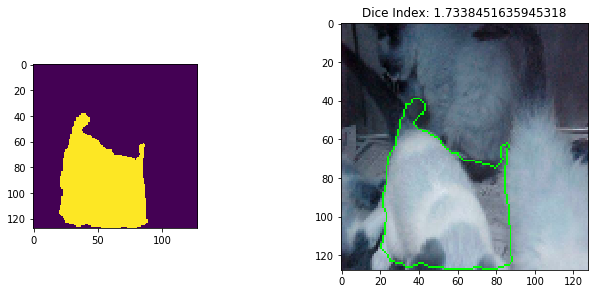

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


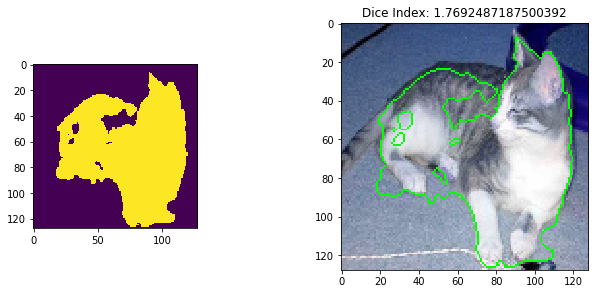

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


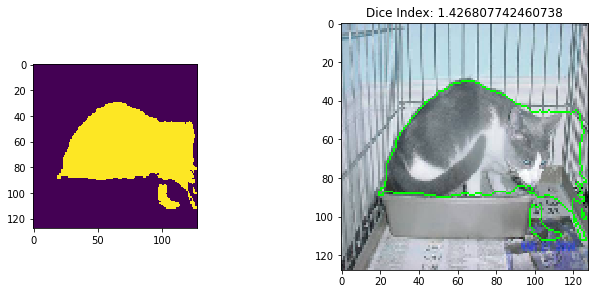

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


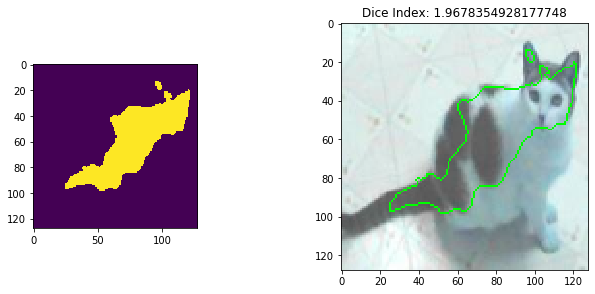

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


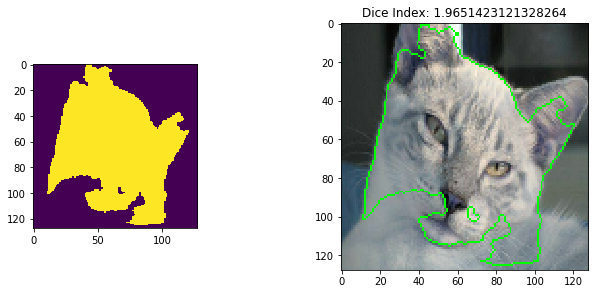

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


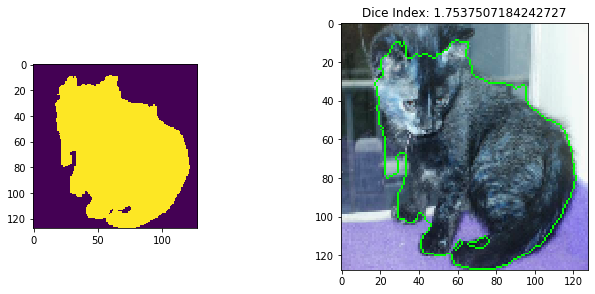

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


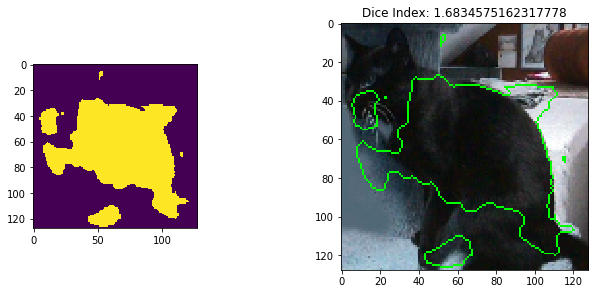

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


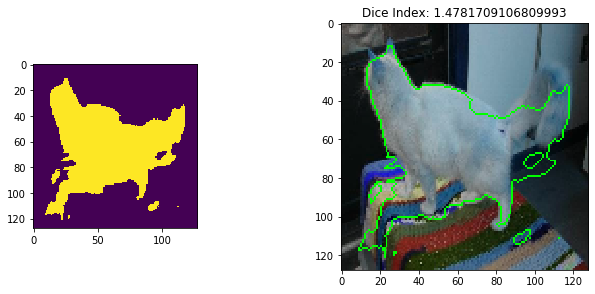

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


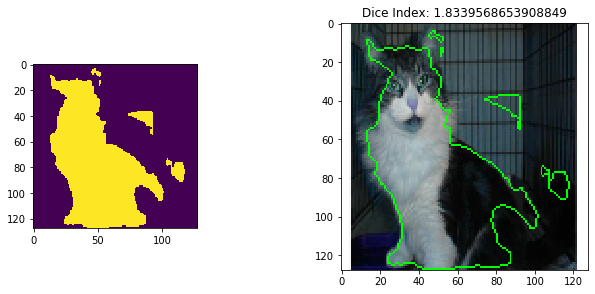

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


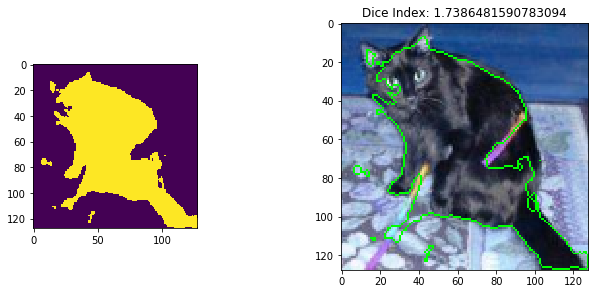

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


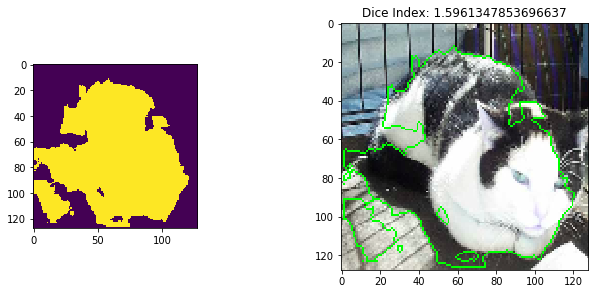

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


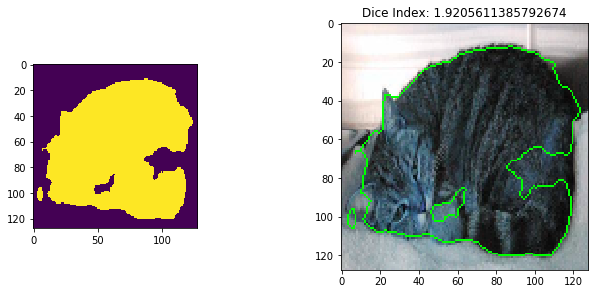

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


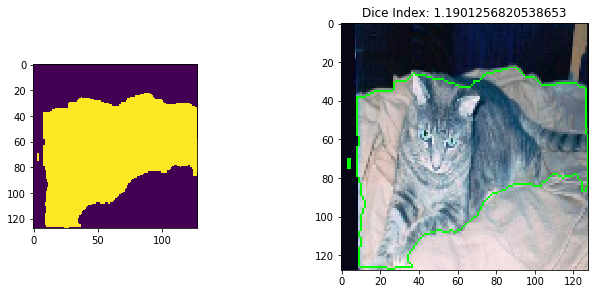

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


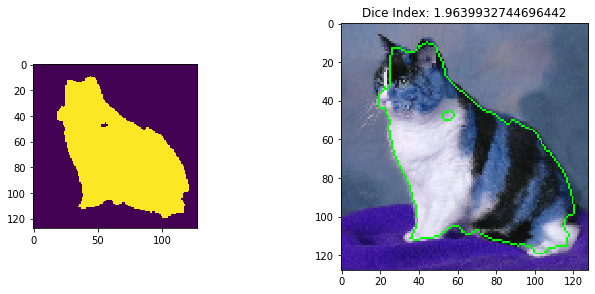

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


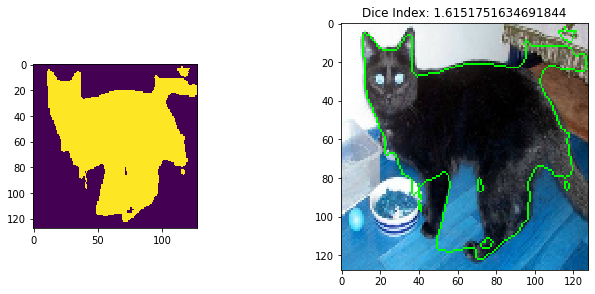

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


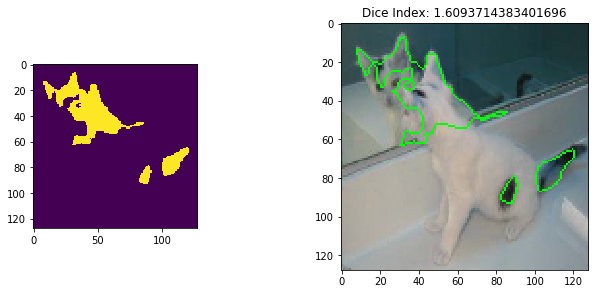

In [0]:
# cat_model = unet_model((IMG_WIDTH, IMG_HEIGHT, 3))
# cat_model.load_weights(MAIN_DIR_PATH + "/" + "cat_model.hdf5")
test_model(cat_model_t, MAIN_DIR_PATH + "/data/cat_data/Test/input", 
           MAIN_DIR_PATH + "/data/cat_data/Test/mask", 
           visualize_segmentations_with_contours)

In [0]:
cat_model_t.summary()
for i in range(len(cat_model_t.layers)):
  print("[" + str(i) + "]" + str(cat_model_t.layers[i].name) + " | " + str(cat_model_t.layers[i].output_shape))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 1792        input1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 64) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________